<a href="https://colab.research.google.com/github/peteray-dev/ML_Adv/blob/master/Personal_work_on_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 44.4 MB/s eta 0:00:00


In [2]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [4]:
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.6 MB/s eta 0:00:00


In [5]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017_2223/main/datasets/bike.csv'
bike = pd.read_csv(url)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [6]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [7]:
for column in bike.columns:
  if bike[column].dtype == 'object':
    unique_values = bike[column].unique()
    print(f"{column}: {unique_values}")

season: ['WINTER' 'SPRING' 'SUMMER' 'FALL']
mnth: ['JAN' 'FEB' 'MAR' 'APR' 'MAY' 'JUN' 'JUL' 'AUG' 'SEP' 'OCT' 'NOV' 'DEC']
holiday: ['NO HOLIDAY' 'HOLIDAY']
weekday: ['SAT' 'SUN' 'MON' 'TUE' 'WED' 'THU' 'FRI']
workingday: ['NO WORKING DAY' 'WORKING DAY']
weathersit: ['MISTY' 'GOOD' 'RAIN/SNOW/STORM']


In [8]:
X = bike.drop(columns = 'cnt')
y = bike['cnt']

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=0
#     )

X.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,4


In [10]:
bike['yr'].unique()

array([2011, 2012])

In [11]:
X.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'days_since_2011'],
      dtype='object')

In [12]:
bin_cat = ['holiday', 'workingday']
tar_cat = ['season', 'mnth', 'weekday', 'weathersit']
num = ['yr', 'temp', 'hum', 'windspeed', 'days_since_2011' ]

In [13]:
X.select_dtypes(exclude='object').columns.tolist()

['yr', 'temp', 'hum', 'windspeed', 'days_since_2011']

<Axes: xlabel='windspeed', ylabel='Count'>

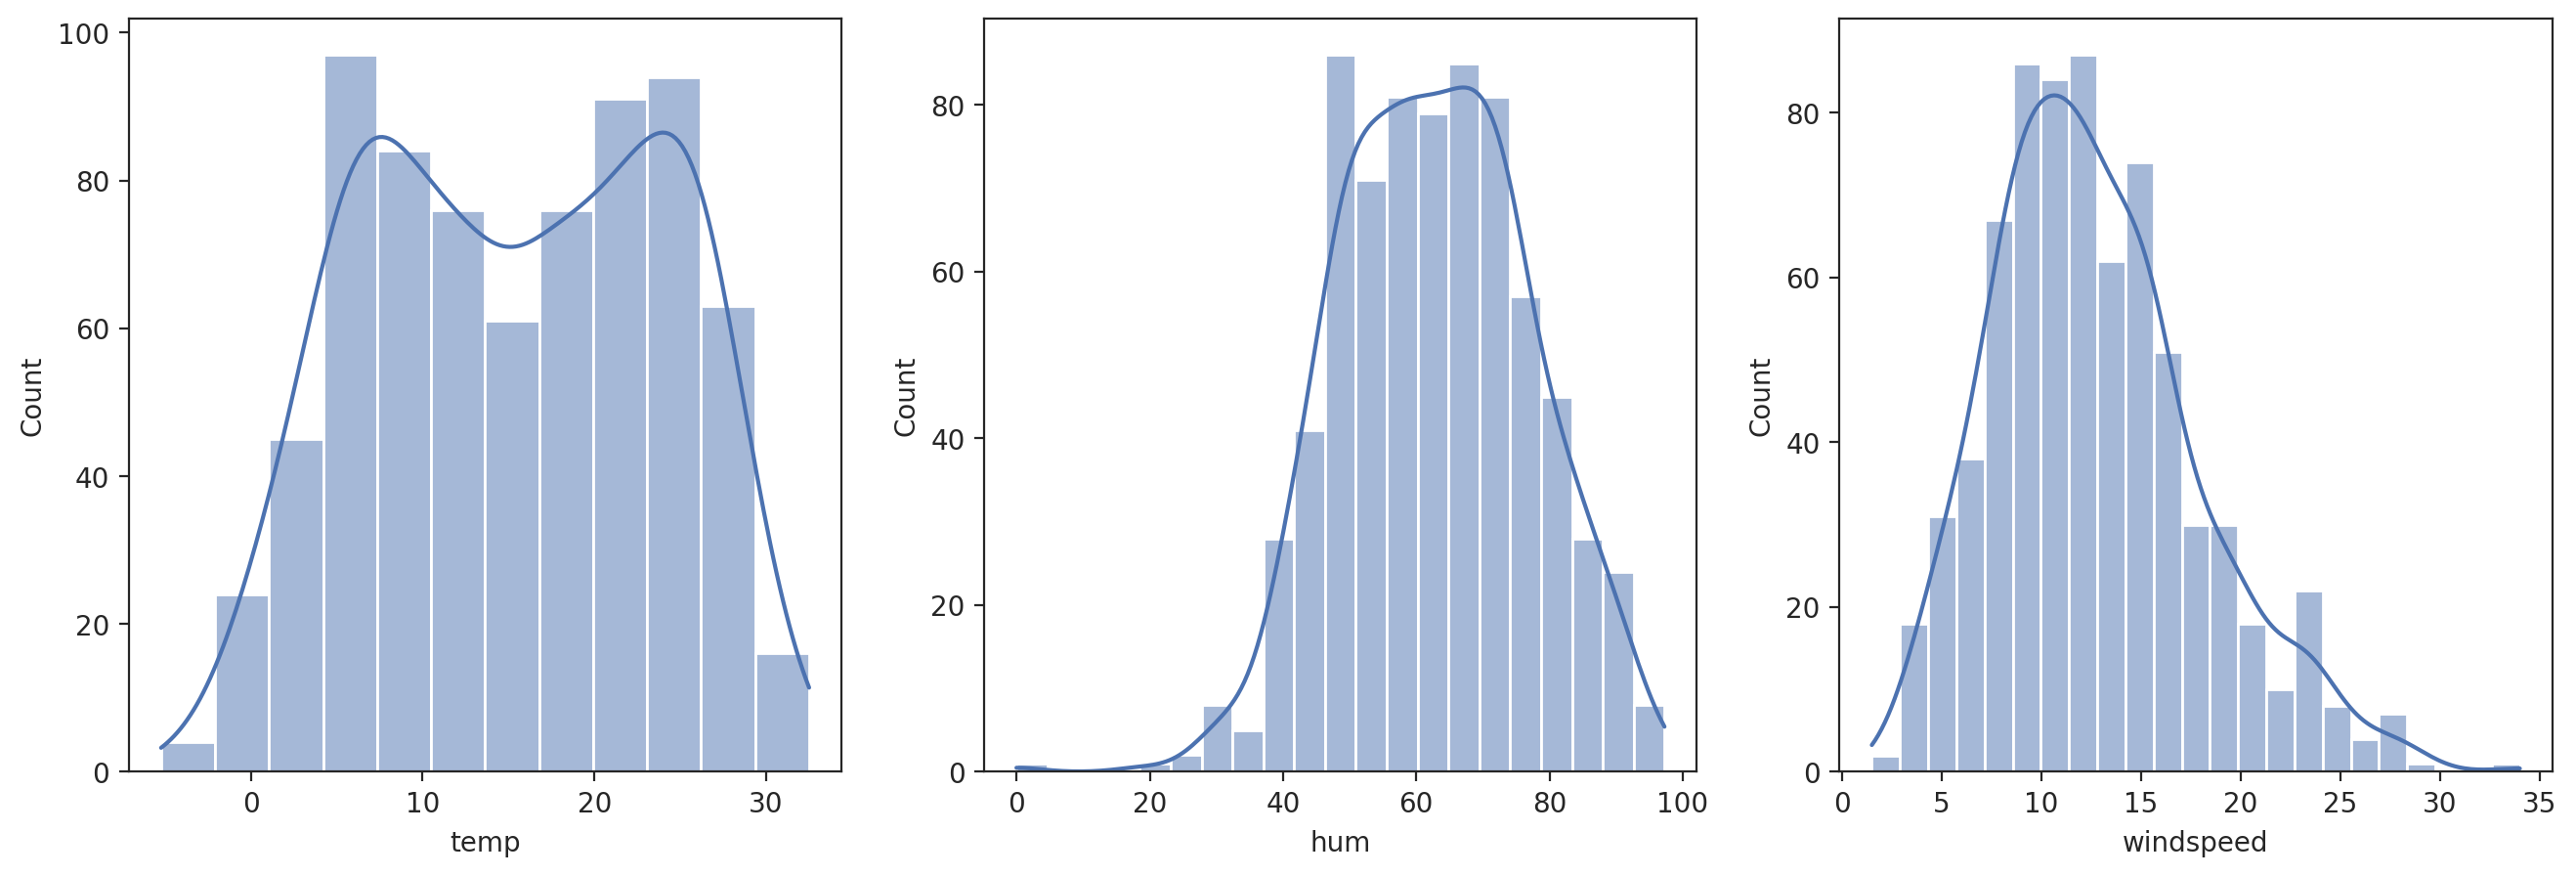

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.histplot(data=bike, x='temp', kde=True, ax=axes[0])
sns.histplot(data=bike, x='hum', kde=True, ax=axes[1])
sns.histplot(data=bike, x='windspeed', kde=True, ax=axes[2])


In [22]:
def Create_pp(X, linear_model=False):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )

    # if we are dealing with a linear model I'll add scaling/polynomial features
    if linear_model:
        numeric_transformer.steps.extend([
            ("scaler", StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ])

    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    return preprocessor

In [23]:
# def Create_pp(X, linear_model=False):
#     bin_cat = ['holiday', 'workingday']
#     tar_cat = ['season', 'mnth', 'weekday', 'weathersit']
#     num = ['yr', 'temp', 'hum', 'windspeed', 'days_since_2011' ]

#     if linear_model:
#         numeric_transformer = Pipeline(
#             steps=[
#                 ('scaler', StandardScaler()),
#                 ('poly', PolynomialFeatures(include_bias=False))
#             ]
#         )

#         cat_ohe_transformer = Pipeline(
#             steps=[
#                 ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'))
#             ]
#         )

#         cat_tar_transformer = Pipeline(
#             steps=[
#                 ('tar', TargetEncoder())  # categories='auto'
#             ]
#         )

#         preprocessor = ColumnTransformer(
#             transformers=[
#                 ("num", numeric_transformer, num),
#                 ('cat_ohe', cat_ohe_transformer, bin_cat),
#                 ('cat_tar', cat_tar_transformer, tar_cat)
#             ],
#             remainder='passthrough',
#             verbose_feature_names_out=False
#         )

#         return preprocessor

In [24]:
def create_regr_ppln(est, X, linear_model=False):
    """ """
    regr_pipe = Pipeline(
        steps=[
            ("pp", Create_pp(X, linear_model)),
            ("regr", est)
        ]
    )

    return regr_pipe

In [25]:
X

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,4
...,...,...,...,...,...,...,...,...,...,...,...
726,WINTER,2012,DEC,NO HOLIDAY,THU,WORKING DAY,MISTY,3.945849,65.2917,23.458911,726
727,WINTER,2012,DEC,NO HOLIDAY,FRI,WORKING DAY,MISTY,3.906651,59.0000,10.416557,727
728,WINTER,2012,DEC,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,3.906651,75.2917,8.333661,728
729,WINTER,2012,DEC,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,4.024151,48.3333,23.500518,729


In [26]:
X_p = Create_pp(X)
X_pro = X_p.fit_transform(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pro, y, test_size=0.2, random_state=0
    )

In [28]:
# Hyperparameter tuning

my_models = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor()
]

# Define parameter grids for each model
param_grid = [
    {
        'n_neighbors': [3, 5, 7]
    },
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 4, 7, 9]
    },
    {
        'n_estimators': [50, 100, 150],
        'max_depth': [5,7,8,10]
    }
]

# Perform GridSearchCV for each model
for model, params in zip(my_models, param_grid):

    grid_search = GridSearchCV(model, params, cv=5, scoring=None, n_jobs=-1)

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Print best parameters and best score for each model
    print("Best Parameters for {}: {}".format(model.__class__.__name__, grid_search.best_params_))
    print("Best Score for {}: {}".format(model.__class__.__name__, grid_search.best_score_))

Best Parameters for KNeighborsRegressor: {'n_neighbors': 3}
Best Score for KNeighborsRegressor: 0.8075117489103748
Best Parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best Score for GradientBoostingRegressor: 0.8813889080966291
Best Parameters for RandomForestRegressor: {'max_depth': 10, 'n_estimators': 100}
Best Score for RandomForestRegressor: 0.8617059251419749


In [29]:
gbr  = create_regr_ppln(GradientBoostingRegressor(max_depth=3, learning_rate=0.1, n_estimators=150 ), X_train)
rfr  = create_regr_ppln(RandomForestRegressor(max_depth=10, n_estimators=150), X_train)
lr   = create_regr_ppln(LinearRegression(), X_train, linear_model=True)
knn = create_regr_ppln(KNeighborsRegressor(n_neighbors=3), X_train)

In [30]:
my_models = [ gbr, rfr, lr, knn]

In [31]:
model_results_list = []
for my_model in my_models:
    eval_results = cross_validate(
        my_model, X_pro, y, cv=5,
        scoring='neg_mean_absolute_error',
        return_train_score=True
    )
    model_results_list.append(
        (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
         -eval_results['train_score'].mean(), eval_results['train_score'].std())
    )

In [32]:
model_results_list

[(703.8574800871376, 222.94772623171988, 221.9574241974361, 11.13880134929674),
 (774.5898338078813, 204.7564493873577, 205.0774781619195, 12.044575852829349),
 (1.12274657826443e+16,
  3619168537151571.0,
  262.3285944268821,
  19.266199111009207),
 (1393.475320721896,
  598.7292817872749,
  375.47043964406987,
  21.782230357749803)]

In [33]:
model_result = pd.DataFrame(
    model_results_list,
    columns = ['test_mae_mean', 'test_mae_std', 'train_mae_mean', 'train_mae_std'],
    index=['gbr', 'rfr', 'lr', 'knn' ]
)

In [34]:
model_result

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbr,7.038575e+02,2.229477e+02,221.957424,11.138801
rfr,7.745898e+02,2.047564e+02,205.077478,12.044576
lr,1.122747e+16,3.619169e+15,262.328594,19.266199
knn,1.393475e+03,5.987293e+02,375.470440,21.782230


In [35]:



# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# # Define the parameter grid
param_grid = [
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__learning_rate': [0.1, 0.01, 0.001]
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__max_depth': [None, 10, 20]
    }
]

# # Define a list of models
# my_models = [KNeighborsRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]

# # Perform GridSearchCV for each model
for model, params in zip(my_models, param_grid):

    grid_search = GridSearchCV(model, params, cv=5, scoring=None, n_jobs=-1)

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Print best parameters and best score for each model
    print("Best Parameters for {}: {}".format(model.__class__.__name__, grid_search.best_params_))
    print("Best Score for {}: {}".format(model.__class__.__name__, grid_search.best_score_))


ValueError: Invalid parameter 'regressor' for estimator Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['yr', 'temp', 'hum',
                                                   'windspeed',
                                                   'days_since_2011',
                                                   'season_FALL',
                                                   'season_SPRING',
                                                   'season_SUMMER',
                                                   'season_WINTER', 'mnth_APR',
                                                   'mnth_AUG', 'mnth_DEC',
                                                   'mnth_FEB', 'mnth_JAN',
                                                   'mnth_JUL', 'mnth_JUN',
                                                   'mnth_MAR', 'mnth_MAY',
                                                   'mnth_NOV...
                                                   'weekday_SAT', 'weekday_SUN',
                                                   'weekday_THU', 'weekday_TUE',
                                                   'weekday_WED',
                                                   'workingday_WORKING DAY', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('regr', GradientBoostingRegressor(n_estimators=150))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [36]:
from sklearn.decomposition import PCA

In [39]:
X_train

,yr,temp,hum,windspeed,days_since_2011,season_FALL,season_SPRING,season_SUMMER,season_WINTER,mnth_APR,...,weekday_MON,weekday_SAT,weekday_SUN,weekday_THU,weekday_TUE,weekday_WED,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
97,2011.0,7.784151,83.6250,15.208464,97.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
503,2012.0,18.515849,52.3333,9.166739,503.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
642,2012.0,22.902500,72.2917,7.875582,642.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
498,2012.0,20.787500,57.6250,15.082839,498.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
303,2011.0,7.980000,70.3333,7.125450,303.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2012.0,9.938349,91.1250,6.792393,707.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
192,2011.0,29.325849,55.9167,13.417018,192.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
629,2012.0,20.160849,66.8750,10.333343,629.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
559,2012.0,26.388349,48.5833,5.416950,559.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [41]:

pca = PCA(n_components=4)

pca.fit(X_train)

# transform data onto the first two principal components
X_pca = pca.transform(X_train)
print("Original shape: {}".format(str(X_train.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))


Original shape: (584, 33)
Reduced shape: (584, 4)


In [42]:
X_pca

,pca0,pca1,pca2,pca3
97,-267.051902,20.077362,-8.803571,3.120733
503,139.015634,-9.264735,4.238037,-3.753000
642,278.049132,10.970182,4.853321,-2.520031
498,134.013294,-4.332946,5.291834,2.774484
303,-61.033863,7.518635,-7.365468,-5.615754
...,...,...,...,...
707,342.975942,27.769175,-10.965965,-2.927003
192,-171.923156,-4.254605,16.018921,0.990186
629,265.023436,4.992913,2.910389,-0.863586
559,195.073489,-11.548902,12.476226,-6.956632


In [45]:
pca.explained_variance_ratio_


array([9.93414540e-01, 4.42386114e-03, 1.57604739e-03, 5.23626325e-04])

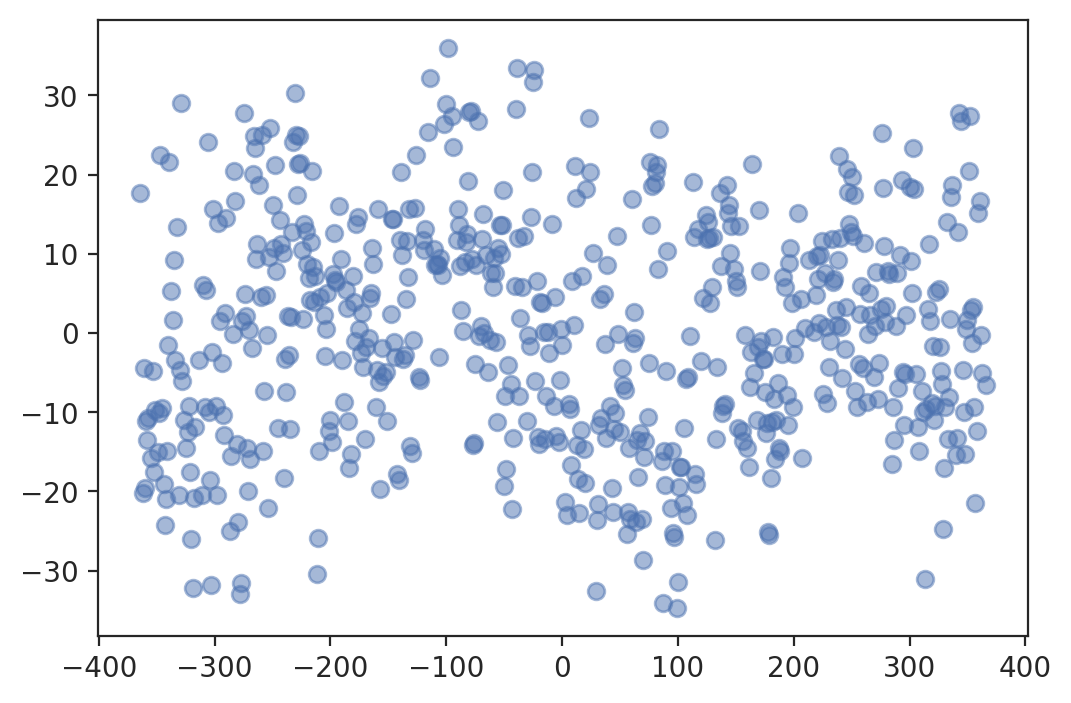

In [44]:
plt.scatter(x=X_pca['pca0'], y=X_pca['pca1'], alpha=0.5)

NameError: name 'pca_full' is not defined

In [49]:
pca_full = PCA()
pca_full.fit(X_train)


PCA()

In [50]:
pca_full.explained_variance_ratio_

array([9.93414540e-01, 4.42386114e-03, 1.57604739e-03, 5.23626325e-04,
       8.09245370e-06, 6.99699382e-06, 6.86526367e-06, 5.64811422e-06,
       3.29773731e-06, 3.17187258e-06, 3.16038567e-06, 3.13439195e-06,
       3.09612610e-06, 2.68184624e-06, 1.98540485e-06, 1.90954848e-06,
       1.89512930e-06, 1.81674589e-06, 1.78132496e-06, 1.68666896e-06,
       1.53586183e-06, 9.55202404e-07, 7.15427409e-07, 6.30704361e-07,
       4.48312903e-07, 2.87189834e-07, 1.26355612e-07, 5.87689395e-09,
       7.46463462e-33, 7.46463462e-33, 7.46463462e-33, 7.46463462e-33,
       7.46463462e-33])

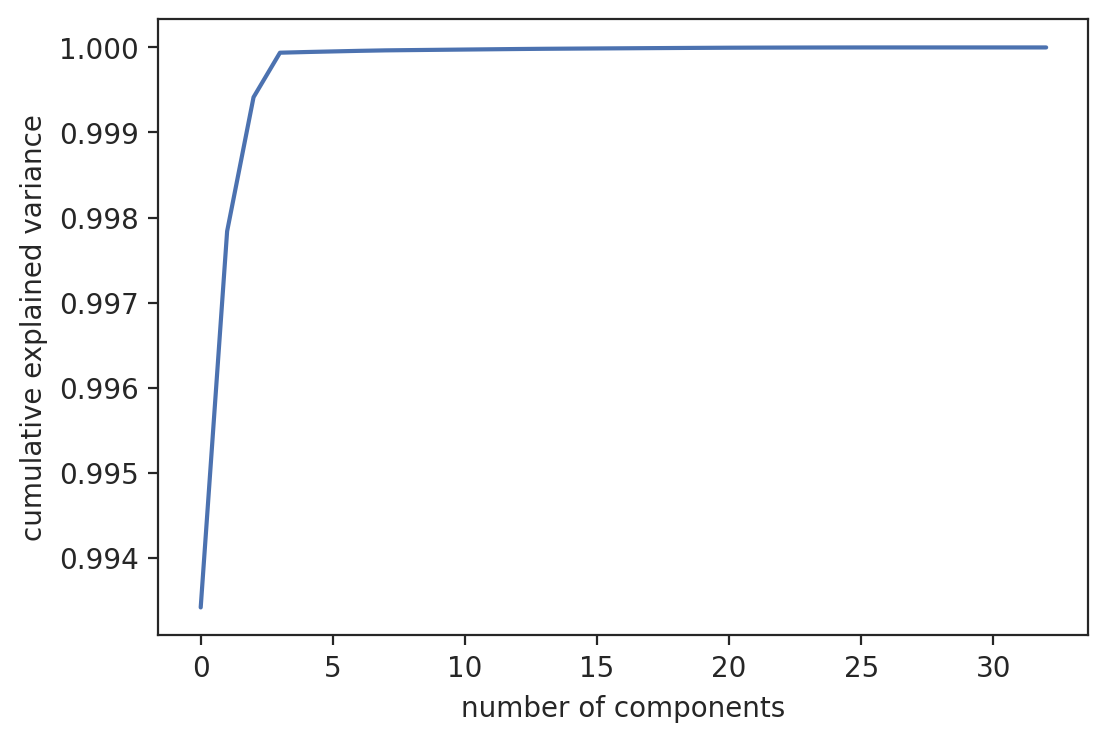

In [51]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');